Shape of scaled_data: (2516, 2)
Epoch 1/100


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0100 - val_loss: 0.0686
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9526e-04 - val_loss: 2.1706e-04
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3554e-05 - val_loss: 2.6669e-04
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4971e-05 - val_loss: 2.3177e-04
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5959e-05 - val_loss: 2.5873e-04
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2762e-05 - val_loss: 2.7580e-04
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3357e-05 - val_loss: 3.0778e-04
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7247e-05 - val_loss: 2.0313e-04
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3242e-05 - val_loss: 2.9564e-04
Epoch 10/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5124e-05 - val_loss: 2.0122e-04
Epoch 11/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0552e-05 - val_loss: 3.7053

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

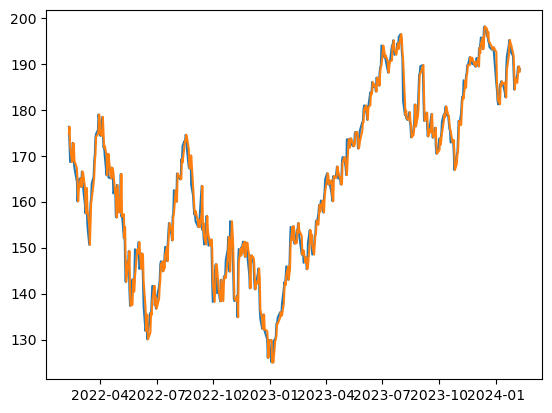

In [13]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the data
asset_list = ['AAPL']
folder_path = "..\Data Collection & Processing\historical_prices_data" 

for asset in asset_list: 
    file_path = os.path.join(folder_path, f"{asset}.csv")
    # Import the dataset into a Pandas Dataframe
    df = pd.read_csv(
        file_path,  
        index_col='Date', 
        infer_datetime_format=True, 
        parse_dates=True
    )

# Create a new DataFrame with shifted 'Close' prices
df['Close_Shifted'] = df['Close'] - df['Close'].shift(1)

# Drop the last row which contains NaN due to shifting
df = df.dropna()

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df[['Close', 'Close_Shifted']])

# Split the data into x_train and y_train data sets
x_train = scaled_data[:, 0]  # Close prices
y_train = scaled_data[:, 1]  # Shifted Close prices

# Reshape the data for LSTM input
x_train = np.reshape(x_train, (x_train.shape[0], 1, 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Create the testing data set
x_test = scaled_data[:, 0]  # Close prices
y_test = scaled_data[:, 1]  # Shifted Close prices

# Reshape the data for LSTM input
x_test = np.reshape(x_test, (x_test.shape[0], 1, 1))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Calculate MSE and RMSE
mse = np.mean((predictions - df['Close_Shifted'].values) ** 2)
rmse = np.sqrt(mse)
mse, rmse
